<a href="https://colab.research.google.com/github/amousavi9/Machine-Translation-Transformer/blob/main/persian_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hazm # Python library for digesting Persian text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 7.1 MB/s 
     |████████████████████████████████| 233 kB 63.1 MB/s 
     |████████████████████████████████| 1.4 MB 56.8 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=c85fe4c8d6278794ca46dc57bbddc7b06f85f3cd14e29e0541786625c25525f7
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154699 sha256=c491b198db58db2ed00950f7fe6095cf66aca8edb679cb9e72cdbd1852e2e095
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [2]:
from __future__ import unicode_literals
import hazm

import re
import string
import random
import requests
import numpy as np
from zipfile import ZipFile
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##Preparing the data

In [3]:
strip_chars = string.punctuation # to remove punctuation from a string

def text_preprocessing(x):
  x = x.lower().strip() # The strip() method removes any leading (spaces) and trailing (spaces) characters 
  x = x.replace("[^A-Za-z]","")
  x = x.replace("\s+"," ")
  x = x.replace("؛"," ")
  x = x.replace("،"," ")
  x = x.replace("؟"," ")
  x = " ".join([word for word in x.split() if len(word)>1])
  x = ''.join(ch for ch in x if ch not in strip_chars)
  x = x.rstrip().strip() # The rstrip() method removes any trailing characters (characters at the end a string)
  return x

In [4]:
url = 'https://www.manythings.org/anki/pes-eng.zip'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

r = requests.get(url, headers=headers)
# save the file:
open('my_file.zip', 'wb').write(r.content)
!unzip 'my_file.zip'

Archive:  my_file.zip
  inflating: _about.txt              
  inflating: pes.txt                 


In [5]:
path_file = 'pes.txt'
with open(path_file, mode='r') as f:
    lines = f.read().strip().split("\n")[:-1]
f.close()

normalizer = hazm.Normalizer() # Modifying Characters to make processing easier in Persian language
en_list, fa_list = [], []
for line in lines:
  eng = text_preprocessing(line.split("\t")[0])
  pes = text_preprocessing(line.split("\t")[1])

  pes = normalizer.normalize(pes)
  pes = "startseq " + pes + " endseq"
  en_list.append(eng)
  fa_list.append(pes)

In [6]:
idx = random.randint(0, len(en_list))
print("Sample input sentence:", en_list[idx])
print("Sample output sentence:", fa_list[idx])

Sample input sentence: this man is very very old
Sample output sentence: startseq این مرد خیلی خیلی پیر است endseq


##Word Cloud Generator to Visualize Data

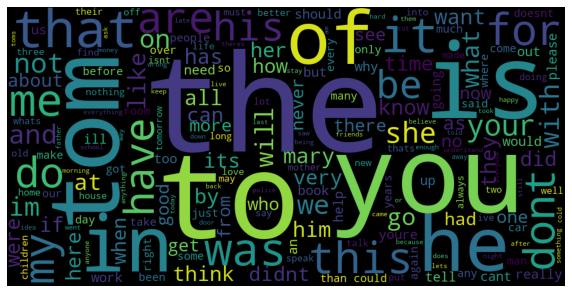

In [7]:
def top_words(captions):
  tokenizer_top_words = [str(word).lower() for line in captions for word in line.split()]
  tokenizer_top_words_count = Counter(tokenizer_top_words)
  wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)

  plt.figure(figsize = (10, 8))
  plt.imshow(wordcloud_token)
  plt.grid(b = None)
  plt.axis('off');

top_words(en_list)

##Finding the best maxlength paramerter

In [8]:
en_lengths = [len(t.split()) for t in en_list]
fa_lengths = [len(t.split()) for t in fa_list]

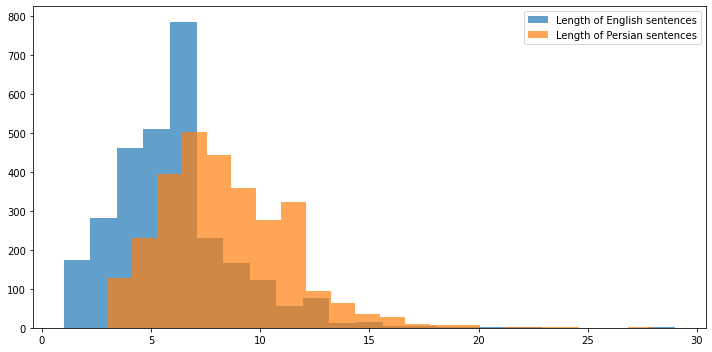

In [9]:
plt.figure(figsize=(10,5))
plt.hist(en_lengths,bins=len(set(en_lengths)), alpha=0.7, label='Length of English sentences')
plt.hist(fa_lengths,bins=len(set(fa_lengths)), alpha=0.7, label='Length of Persian sentences')
plt.tight_layout()
plt.legend()
plt.show()

##Train Test Split

In [10]:
en_list_train, en_list_val, fa_list_train, fa_list_val  = train_test_split(en_list, fa_list, test_size=0.10, shuffle=True)
en_list_val, en_list_test, fa_list_val, fa_list_test  = train_test_split(en_list_val, fa_list_val, test_size=0.10, shuffle=True)

##Tokenization

In [11]:
batch_size = 32
seq_length = 20 # Maximum length of sequences
embed_size = 256 # how big is each word vector

In [12]:
def create_tokenizer(sentences):
  text_tokenizer = Tokenizer()
  text_tokenizer.fit_on_texts(sentences)

  return text_tokenizer

def text_to_sequence(sentences, tokenizer, max_length):
  tensor = tokenizer.texts_to_sequences(sentences)
  tensor = pad_sequences(tensor, padding='post', maxlen=max_length)
  return tensor

In [13]:
en_tokenizer = create_tokenizer(en_list_train)
fa_tokenizer = create_tokenizer(fa_list_train)

In [14]:
en_tensor_train = text_to_sequence(en_list_train, en_tokenizer, seq_length)
fa_tensor_train = text_to_sequence(fa_list_train, fa_tokenizer, seq_length+1)

en_tensor_val = text_to_sequence(en_list_val, en_tokenizer, seq_length)
fa_tensor_val = text_to_sequence(fa_list_val, fa_tokenizer, seq_length+1)

##Create Dataset

In [15]:
vocab_en_size = len(en_tokenizer.word_index) + 1
vocab_fa_size = len(fa_tokenizer.word_index) + 1

def format_dataset(eng, fa):
    return ({
        "encoder_inputs": eng,
        "decoder_inputs": fa[:, :-1],
    }, fa[:, 1:])
    
def create_dataset(eng_tensor, pes_tensor):
    dataset = tf.data.Dataset.from_tensor_slices((eng_tensor, pes_tensor))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(1024).prefetch(16).cache()

train_ds = create_dataset(en_tensor_train, fa_tensor_train)
val_ds = create_dataset(en_tensor_val, fa_tensor_val)

In [16]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'] shape: {inputs['encoder_inputs'].shape}")
    print(f"inputs['spanish'] shape: {inputs['decoder_inputs'].shape}")
    print(f"targets shape: {targets.shape}")

inputs['english'] shape: (32, 20)
inputs['spanish'] shape: (32, 20)
targets shape: (32, 20)


##Transformer

In [17]:
class Transformer_Encoder(layers.Layer):
  def __init__(self, num_heads, embed_dim, dropout, **kwargs):
    super().__init__(**kwargs)

    self.AttentionLayer = layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim,
                                                    dropout=dropout)
    
    self.LayerNormalization1 = layers.Normalization()
    self.LayerNormalization2 = layers.Normalization()

    self.DenseProjection = keras.models.Sequential([
          layers.Dense(embed_dim * 5, kernel_initializer='HeNormal'),
          layers.LeakyReLU(alpha=0.2),
          layers.Dense(embed_dim)
    ])

  def call(self, inputs):
    out_att = self.AttentionLayer(query=inputs, value=inputs, key=inputs)
    out_norm1 = self.LayerNormalization1(inputs + out_att)

    out_proj = self.DenseProjection(out_norm1)
    out_norm2 = self.LayerNormalization2(out_proj + out_norm1)

    return out_norm2

In [18]:
class Positional_Embedding(layers.Layer):
  def __init__(self, embed_dim, vocab_size, **kwargs):
    super().__init__(**kwargs)

    self.TokenEmbedding = layers.Embedding(input_dim=vocab_size,
                                              output_dim=embed_dim)
    
    self.PositionalEmbedding = layers.Embedding(input_dim=seq_length,
                                                  output_dim=embed_dim)
  
  def call(self, inputs):
    out_tk = self.TokenEmbedding(inputs)
    
    positions = tf.range(tf.shape(inputs)[-1])
    out_ps = self.PositionalEmbedding(positions)
   
    return out_tk + out_ps

In [19]:
class Transformer_Decoder(layers.Layer):
  def __init__(self, num_heads, embed_dim, dropout, **kwargs):
    super().__init__(**kwargs)

    self.MaskAttentionLayer = layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim,
                                                    dropout=dropout)

    self.AttentionLayer = layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim,
                                                    dropout=dropout)

    self.DenseProjection = keras.models.Sequential([
          layers.Dense(embed_dim * 5, kernel_initializer='HeNormal'),
          layers.LeakyReLU(alpha=0.2),
          layers.Dense(embed_dim)
    ])

    self.LayerNormalization1 = layers.Normalization()
    self.LayerNormalization2 = layers.Normalization()
    self.LayerNormalization3 = layers.Normalization()


  def call(self, inputs, encoder_outputs):
    attention_mask = self.attentionMask(inputs)

    out_maskAtt = self.MaskAttentionLayer(query=inputs, value=inputs, key=inputs, attention_mask=attention_mask)
    out_norm1 = self.LayerNormalization1(inputs + out_maskAtt)

    out_att = self.AttentionLayer(query=out_norm1, value=encoder_outputs, key=encoder_outputs)
    out_norm2 = self.LayerNormalization2(out_att + out_norm1)

    out_proj = self.DenseProjection(out_norm2)
    output = self.LayerNormalization3(out_proj + out_norm2)
    return output
  
  def attentionMask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, seq_length = input_shape[0], input_shape[1]

    i = tf.range(seq_length)[:, tf.newaxis]
    j = tf.range(seq_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0,)
  
    return tf.tile(mask, mult)

###Create Encoder

In [45]:
# Positional Embedding --Encoder
positional_embd_enc = Positional_Embedding(embed_dim=embed_size, vocab_size=vocab_en_size)

for inputs, targets in train_ds.take(1):
    out_po_enc = positional_embd_enc(inputs['encoder_inputs'])
    print(out_po_enc.shape)

(32, 20, 256)


In [46]:
# Transformer Encoder
transformer_enc = Transformer_Encoder(num_heads=8, embed_dim=embed_size, dropout=0.3)

out_enc = transformer_enc(out_po_enc)
print(out_enc.shape)

(32, 20, 256)


###Create Decoder

In [47]:
# Positional Embedding --Decoder
positional_embd_dec = Positional_Embedding(embed_dim=embed_size, vocab_size=vocab_fa_size)
for inputs, targets in train_ds.take(1):
    out_po_dec = positional_embd_dec(inputs['decoder_inputs'])
    print(out_po_dec.shape)

(32, 20, 256)


In [48]:
# Transformer Decoder
transformer_dec = Transformer_Decoder(num_heads=8, embed_dim=embed_size, dropout=0.3)

out_dec = transformer_dec(out_po_dec, out_enc)
print(out_dec.shape)

(32, 20, 256)


## End-to-end Transformer


In [49]:
# encoder
encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")

embed_output_enc = positional_embd_enc(encoder_inputs)
encoder_outputs = transformer_enc(embed_output_enc)

Encoder = keras.Model(inputs=encoder_inputs, outputs=encoder_outputs)

# decoder
decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
decoder_inputs2 = keras.Input(shape=(None, embed_size), name="decoder_inputs2")

embed_output_dec = positional_embd_dec(decoder_inputs)
decoder_output = transformer_dec(embed_output_dec, decoder_inputs2)
decoder_output = layers.Dropout(0.5)(decoder_output)

final_output = layers.Dense(vocab_fa_size, activation="softmax")(decoder_output)

Decoder = keras.Model(inputs=[decoder_inputs, decoder_inputs2], outputs=final_output)

# transformer
decoder_output = Decoder([decoder_inputs, encoder_outputs])

Transformer = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_output)

In [50]:
Transformer.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional__embedding_6 (Posit  (None, None, 256)   701952      ['encoder_inputs[0][0]']         
 ional_Embedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer__encoder_3 (Transf  (None, None, 256)   2761474     ['positional__embedding_6[

In [51]:
EPOCHS = 100
Callbacks = [keras.callbacks.ModelCheckpoint("transformer_checkpoint"),
             keras.callbacks.EarlyStopping(monitor='loss', patience=5)]

Transformer.compile(
    optimizer="Adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/100
82/82 [==============================] - 28s 31ms/step - loss: 2.6954 - accuracy: 0.6590 - val_loss: 1.8992 - val_accuracy: 0.7206
Epoch 2/100
82/82 [==============================] - 2s 24ms/step - loss: 2.1651 - accuracy: 0.6924 - val_loss: 1.8462 - val_accuracy: 0.7260
Epoch 3/100
82/82 [==============================] - 2s 24ms/step - loss: 2.0642 - accuracy: 0.7004 - val_loss: 1.8361 - val_accuracy: 0.7326
Epoch 4/100
82/82 [==============================] - 2s 25ms/step - loss: 1.9746 - accuracy: 0.7075 - val_loss: 1.8178 - val_accuracy: 0.7357
Epoch 5/100
82/82 [==============================] - 2s 25ms/step - loss: 1.9046 - accuracy: 0.7126 - val_loss: 1.8365 - val_accuracy: 0.7370
Epoch 6/100
82/82 [==============================] - 2s 25ms/step - loss: 1.8131 - accuracy: 0.7194 - val_loss: 1.8200 - val_accuracy: 0.7420
Epoch 7/100
82/82 [==============================] - 2s 25ms/step - loss: 1.7039 - accuracy: 0.7288 - val_loss: 1.8203 - val_accuracy: 0.7473
Epoch

##Test

In [52]:
def decode_sequence(tokenized_input_sentence):
    decoded_sentence = "startseq"
 
    for i in range(seq_length):
        tokenized_target_sentence = text_to_sequence([decoded_sentence], fa_tokenizer, seq_length +1)[:, :-1]
      
        predictions = Transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fa_tokenizer.index_word[sampled_token_index]

        decoded_sentence += " " + sampled_token
        if sampled_token == "endseq":
            break
    return decoded_sentence


for _ in range(15):
  input_sentence = random.choice(en_list_test)

  encoded_seq = text_to_sequence([input_sentence], en_tokenizer, seq_length)
  output = decode_sequence(encoded_seq)

  print(input_sentence)
  print(output)
  print('-----------------------------------------------')

tom is fanatic
startseq تام سر زد endseq
-----------------------------------------------
just wanted to check my email
startseq فقط می‌خواهم پولم به من بده endseq
-----------------------------------------------
study at school
startseq هر روز حمام می‌کنم endseq
-----------------------------------------------
be careful not to scratch the furniture
startseq یکی دیگه چین نقش فعالی خواهد داشت endseq
-----------------------------------------------
come with me
startseq بیا با من بروی endseq
-----------------------------------------------
tom died before the ambulance arrived
startseq تام قبل از رسیدن آمبولانس مرد endseq
-----------------------------------------------
do love you
startseq آیا شما آموزگار هستید endseq
-----------------------------------------------
tell me
startseq به من نگو endseq
-----------------------------------------------
if he calls tell him will get in touch with him later
startseq اگر او را به اعدام محکوم کرد endseq
-----------------------------------------------
t